In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization

C:\Users\flame\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
x_train = pd.read_csv('X_train.csv')
y_trains = pd.read_csv('Y_train.csv')
test = pd.read_csv('X_test.csv')

In [3]:
x_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
x_train.columns

Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')

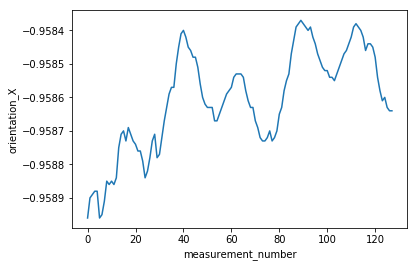

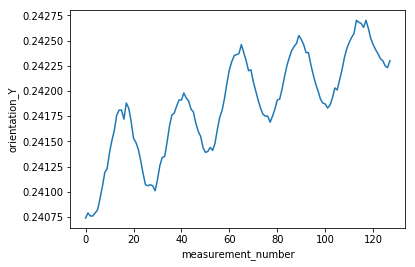

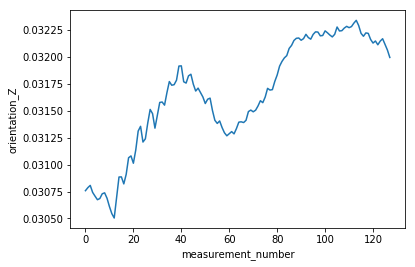

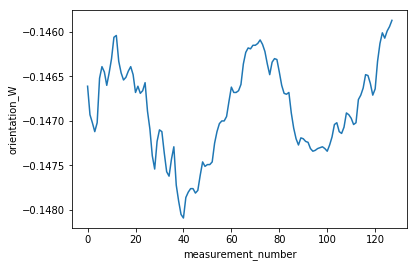

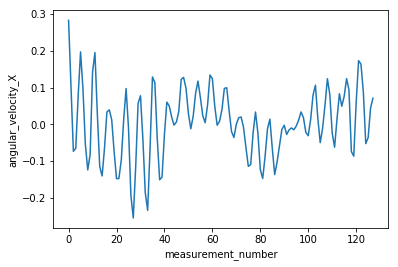

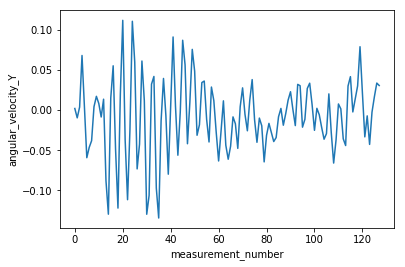

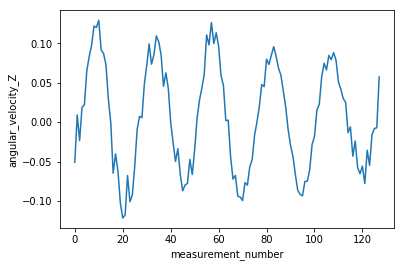

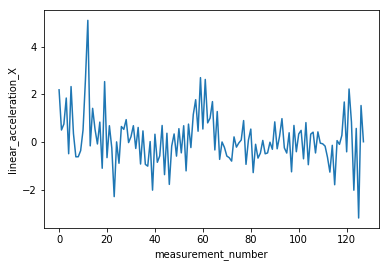

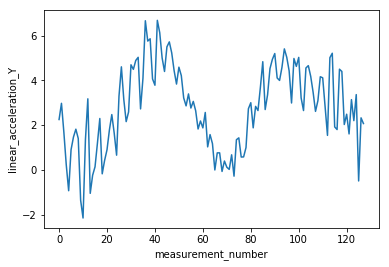

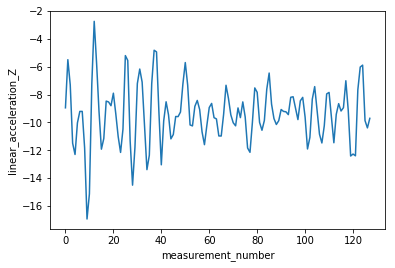

In [5]:
for col in x_train.columns[3:]:
    sns.lineplot(x =x_train['measurement_number']  , y = x_train.loc[x_train['series_id'] == 1, col])
    plt.show()

In [6]:
train_df = x_train[['series_id']].drop_duplicates().reset_index(drop=True)

In [7]:
velocity_squared = np.power(x_train['angular_velocity_X'],2)+np.power(x_train['angular_velocity_Y'],2)+np.power(x_train['angular_velocity_Z'],2)
x_train['velocity_mag'] = np.sqrt(velocity_squared)
acc_squared = np.power(x_train['linear_acceleration_X'],2)+np.power(x_train['linear_acceleration_Y'],2)+np.power(x_train['linear_acceleration_Z'],2)
x_train['acc_mag'] = np.sqrt(acc_squared)

In [8]:
velocity_squared = np.power(test['angular_velocity_X'],2)+np.power(test['angular_velocity_Y'],2)+np.power(test['angular_velocity_Z'],2)
test['velocity_mag'] = np.sqrt(velocity_squared)
acc_squared = np.power(test['linear_acceleration_X'],2)+np.power(test['linear_acceleration_Y'],2)+np.power(test['linear_acceleration_Z'],2)
test['acc_mag'] = np.sqrt(acc_squared)

In [11]:
def df_transform(df):
    train_df = df[['series_id']].drop_duplicates().reset_index(drop=True)
    for col in df.columns[3:]:
        for i in train_df['series_id']:
            train_df.loc[i, col + '_q95'] = np.quantile(df.loc[df['series_id'] == i, col], 0.95)
            train_df.loc[i, col + '_q75'] = np.quantile(df.loc[df['series_id'] == i, col], 0.75)
            train_df.loc[i, col + '_q95'] = np.quantile(df.loc[df['series_id'] == i, col], 0.5)
            train_df.loc[i, col + 'mean'] = np.mean(df.loc[df['series_id'] == i, col])
            train_df.loc[i, col + 'max'] = np.max(df.loc[df['series_id'] == i, col])
            train_df.loc[i, col + 'min'] = np.min(df.loc[df['series_id'] == i, col])
            train_df.loc[i, col + 'std'] = np.std(df.loc[df['series_id'] == i, col])
            train_df.loc[i, col + 'std'] = np.min(df.loc[df['series_id'] == i, col])/np.max(df.loc[df['series_id'] == i, col])
    return train_df

In [12]:
train_df = df_transform(x_train)
test_df =df_transform(test)

In [13]:
train_df = train_df.drop('series_id', axis = 1)
test_df = test_df.drop('series_id', axis =1)
train_df.head()

,orientation_X_q95,orientation_X_q75,orientation_Xmean,orientation_Xmax,orientation_Xmin,orientation_Xstd,orientation_Y_q95,orientation_Y_q75,orientation_Ymean,orientation_Ymax,...,velocity_magmean,velocity_magmax,velocity_magmin,velocity_magstd,acc_mag_q95,acc_mag_q75,acc_magmean,acc_magmax,acc_magmin,acc_magstd
0,-0.758530,-0.758367,-0.758666,-0.75822,-0.75953,1.001728,-0.634270,-0.633530,-0.634008,-0.63306,...,0.057668,0.162384,0.010603,0.065297,10.077860,10.516197,9.939676,12.575577,7.117152,0.565950
1,-0.958595,-0.958480,-0.958606,-0.95837,-0.95896,1.000616,0.241890,0.242300,0.241867,0.24270,...,0.111790,0.287947,0.020167,0.070039,10.069950,11.144981,10.082444,16.986332,5.867993,0.345454
2,-0.512035,-0.510947,-0.512057,-0.50944,-0.51434,1.009618,-0.846210,-0.845502,-0.846171,-0.84490,...,0.071090,0.170919,0.009871,0.057754,10.082289,10.620150,10.035741,12.725500,6.794325,0.533914
3,-0.939170,-0.938960,-0.939169,-0.93884,-0.93968,1.000895,0.310115,0.310223,0.310140,0.31147,...,0.156050,0.523568,0.014446,0.027592,10.925683,12.357202,10.888094,20.833299,2.064233,0.099083
4,-0.890940,-0.888750,-0.891301,-0.88673,-0.89689,1.011458,0.428865,0.433475,0.428144,0.43740,...,0.157866,0.231539,0.091379,0.394661,10.005620,10.478288,9.892815,11.485482,8.071708,0.702775


In [14]:
LE = LabelEncoder()
y_trains['surface'] = LE.fit_transform(y_trains['surface'])

In [15]:
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)


In [27]:
d_train = lgb.Dataset(train_df, label=y_trains['surface'])
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 15
params['min_data'] = 50
params['max_depth'] = 10
params['num_classes'] = len(y_trains['surface'])
clf = lgb.train(params, d_train, 100)

In [31]:
params = {'colsample_bytree': 0.6112754814687145,
 'learning_rate': 0.018000611697225076,
 'max_depth': 14,
 'min_child_weight': 2.5734080095299765,
 'min_split_gain': 0.008074108890494421,
 'num_leaves': 56,
 'reg_alpha': 0.26393060850254857,
 'reg_lambda': 1.1205779301627437,
 'subsample': 0.6688886922333233}
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_classes'] = len(y_trains['surface'])
clf = lgb.train(params, d_train, 759)

In [17]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train_df.shape[0], 9))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_trains['surface'])):
        X_train, X_valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
        y_train, y_valid = y_trains['surface'].iloc[train_idx], y_trains['surface'].iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [18]:
params = {'colsample_bytree': (0.6, 0.8),
      'learning_rate': (.0001, .5), 
      'num_leaves': (2, 124), 
      'subsample': (0.6, 1), 
      'max_depth': (3, 120), 
      'reg_alpha': (.001, 15.0), 
      'reg_lambda': (.001, 15.0), 
      'min_split_gain': (.001, .03),
      'min_child_weight': (2, 80)}

bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7473   |  0.7557   |  0.1045   |  116.2    |  53.86    |  0.01034  |  21.02    |  14.7     |  2.966    |  0.6513   |
|  2        |  0.8333   |  0.6293   |  0.303    |  34.74    |  48.62    |  0.02754  |  117.7    |  3.25     |  6.079    |  0.895    |
|  3        |  0.8172   |  0.7077   |  0.4408   |  34.41    |  23.09    |  0.005875 |  16.9     |  12.38    |  8.626    |  0.9131   |
|  4        |  0.8495   |  0.6691   |  0.1826   |  64.51    |  18.39    |  0.02186  |  91.83    |  7.77     |  14.64    |  0.8741   |
|  5        |  0.8172   |  0.731    |  0.3361   |  29.29    |  28.08    |  0.01392  |  110.8    |  10.14    |  8.676    |  0.8784   |
|  6        |  0.871    |  0.6      |  0.5      |  120.0    | 

In [19]:
bo.max['params']

{'colsample_bytree': 0.6112754814687145,
 'learning_rate': 0.018000611697225076,
 'max_depth': 14.727007583749135,
 'min_child_weight': 2.5734080095299765,
 'min_split_gain': 0.008074108890494421,
 'num_leaves': 56.562784597525045,
 'reg_alpha': 0.26393060850254857,
 'reg_lambda': 1.1205779301627437,
 'subsample': 0.6688886922333233}

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6112754814687145,
 'learning_rate': 0.018000611697225076,
 'max_depth': 14,
 'metric': 'multi_logloss',
 'min_child_weight': 2.5734080095299765,
 'min_split_gain': 0.008074108890494421,
 'num_classes': 3810,
 'num_leaves': 56,
 'objective': 'multiclass',
 'reg_alpha': 0.26393060850254857,
 'reg_lambda': 1.1205779301627437,
 'subsample': 0.6688886922333233}

In [ ]:
cv_results = lgb.cv(params, d_train, num_boost_round=2000, nfold=10, 
                   verbose_eval=50, early_stopping_rounds=40)

[50]	cv_agg's multi_logloss: 1.069 + 0.0201476
[100]	cv_agg's multi_logloss: 0.728965 + 0.0216317
[150]	cv_agg's multi_logloss: 0.560536 + 0.0217293
[200]	cv_agg's multi_logloss: 0.466666 + 0.0211737
[250]	cv_agg's multi_logloss: 0.412768 + 0.0214049
[300]	cv_agg's multi_logloss: 0.381184 + 0.0218868
[350]	cv_agg's multi_logloss: 0.361708 + 0.0223213
[400]	cv_agg's multi_logloss: 0.348958 + 0.022419
[450]	cv_agg's multi_logloss: 0.340121 + 0.0227015
[500]	cv_agg's multi_logloss: 0.334273 + 0.0229155
[550]	cv_agg's multi_logloss: 0.329895 + 0.0229716
[600]	cv_agg's multi_logloss: 0.326705 + 0.0229627
[650]	cv_agg's multi_logloss: 0.324344 + 0.0231052
[700]	cv_agg's multi_logloss: 0.322271 + 0.0231298
[750]	cv_agg's multi_logloss: 0.320426 + 0.0232069


In [33]:
y_pred = clf.predict(train_df)
predictions = []
for x in y_pred:
    predictions.append(np.argmax(x))

cm = confusion_matrix(predictions, y_trains['surface'],y_trains['surface'].unique())
accuracy=accuracy_score(predictions,y_trains['surface'])

In [35]:
cm = confusion_matrix(predictions, y_trains['surface'],y_trains['surface'].unique())
accuracy=accuracy_score(predictions,y_trains['surface'])

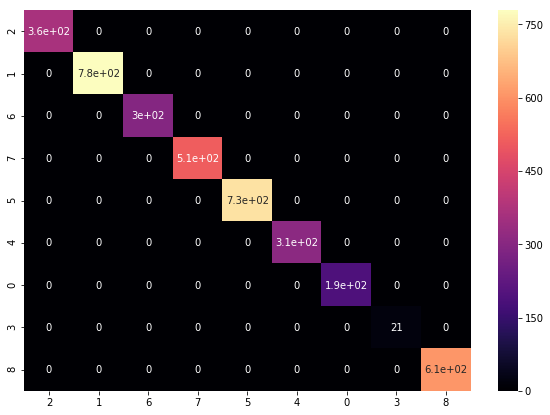

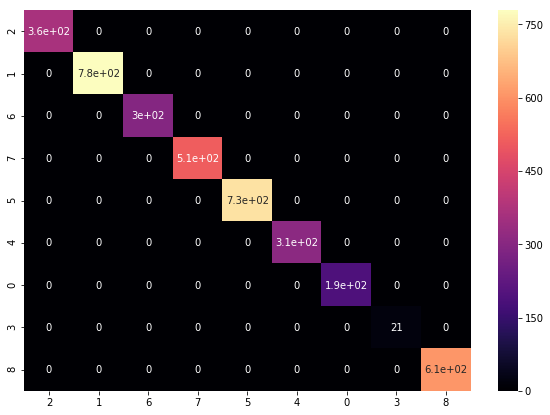

In [39]:
df_cm = pd.DataFrame(cm, index = y_trains['surface'].unique(),
                  columns = y_trains['surface'].unique())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap = 'magma')
plt.show()

In [38]:
accuracy

1.0

In [70]:
num_boost_rounds_lgb = len(cv_results['multi_logloss-mean'])

In [40]:
y_pred = clf.predict(test_df)

In [41]:
predictions = []
for x in y_pred:
    predictions.append(np.argmax(x))

In [42]:
predict = LE.inverse_transform(predictions)
predict

array(['hard_tiles_large_space', 'concrete', 'tiled', ..., 'concrete',
       'concrete', 'wood'], dtype=object)

In [49]:
sub = pd.read_csv('sample_submission.csv')
sub['surface'] = predict
sub.to_csv("submission.csv", index=False)

In [50]:
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles


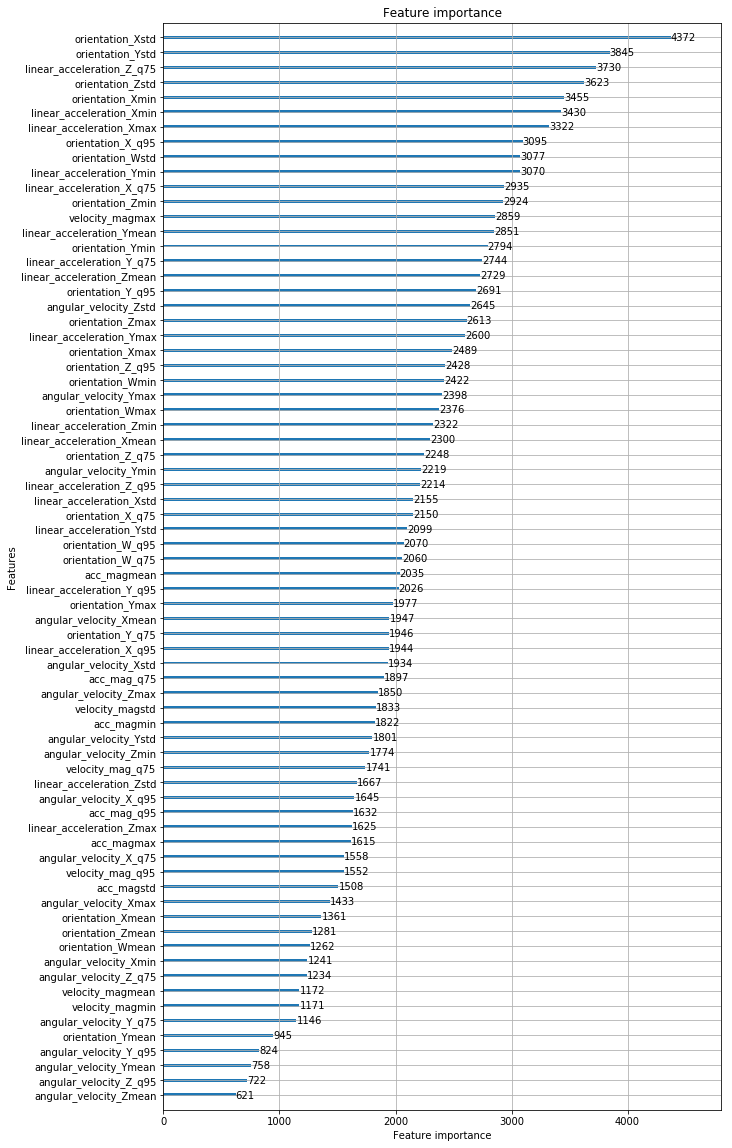

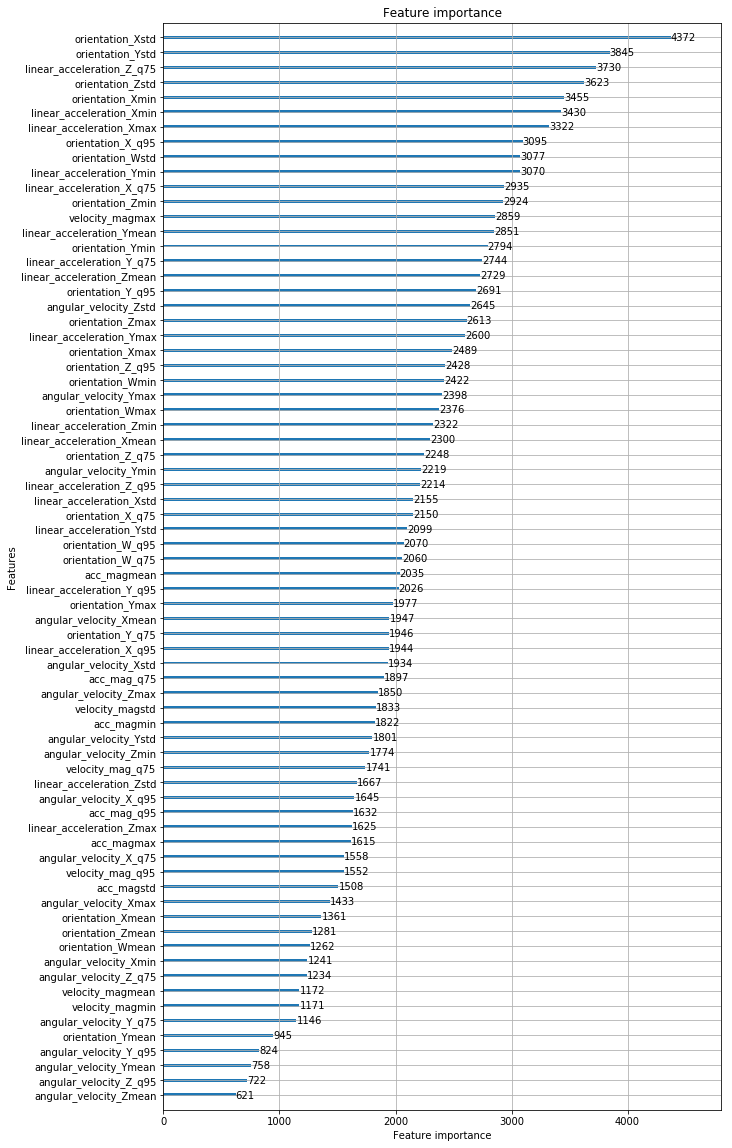

In [46]:
lgb.plot_importance(clf,figsize = (10,20))
plt.show()

In [47]:
sub.to_csv("submission.csv", index=False)

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete
